# Retrieval Imagination Visualizer

Load multiple retrieval runs produced by `src/retrieval_imagination.py`, summarize precision@k across corruption ranges, and drill into qualitative grids for any run you choose.

In [1]:
from pathlib import Path
import json
import random
from typing import Dict, List, Optional

from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
REPO_ROOT = Path("..").resolve()


In [2]:
RESULTS_ROOT = REPO_ROOT / "results"
RESULTS_GLOB = "retrieval_imagination_*"
RESULTS_DIRS = sorted(
    p for p in RESULTS_ROOT.glob(RESULTS_GLOB) if (p / "metrics.json").exists()
)

if not RESULTS_DIRS:
    raise FileNotFoundError("No retrieval_imagination_* result directories with metrics.json found.")

runs: List[Dict] = []
for directory in RESULTS_DIRS:
    metrics_path = directory / "metrics.json"
    samples_path = directory / "samples.json"
    if not samples_path.exists():
        continue
    runs.append(
        {
            "name": directory.name,
            "dir": directory,
            "metrics": json.loads(metrics_path.read_text()),
            "samples": json.loads(samples_path.read_text()),
        }
    )

if not runs:
    raise ValueError("Found directories but none had both metrics.json and samples.json.")

print(f"Loaded {len(runs)} runs:")
for run in runs:
    metrics = run["metrics"]
    corrupt_range = metrics.get("corrupt_range")
    print(
        f" - {run['name']} | scheme={metrics.get('scheme')} | range={corrupt_range} | num_queries={metrics.get('num_queries')}"
    )


Loaded 1 runs:
 - retrieval_imagination_mlp | scheme=occlude | range=[0.5, 0.7] | num_queries=3925


## Precision Across Runs

In [3]:
summary_rows = []
for run in runs:
    metrics = run["metrics"]
    precision = metrics.get("precision", {})
    corrupt_range = metrics.get("corrupt_range") or [None, None]
    summary_rows.append(
        {
            "run": run["name"],
            "scheme": metrics.get("scheme"),
            "corrupt_min": corrupt_range[0],
            "corrupt_max": corrupt_range[1],
            "k": metrics.get("k"),
            "num_queries": metrics.get("num_queries"),
            "fragment@k": precision.get("fragment"),
            "reconstruction@k": precision.get("reconstruction"),
            "clean@k": precision.get("clean"),
        }
    )

summary_df = (
    pd.DataFrame(summary_rows)
    .sort_values(["scheme", "corrupt_min"], na_position="last")
    .reset_index(drop=True)
)
display(summary_df)


run   scheme  corrupt_min  corrupt_max  k  \
0  retrieval_imagination_mlp  occlude          0.5          0.7  5   

   num_queries  fragment@k  reconstruction@k   clean@k  
0         3925    0.898242          0.928408  0.982981

In [4]:
for scheme, sub_df in summary_df.groupby("scheme"):
    fig, ax = plt.subplots(figsize=(6, 4))
    x = sub_df["corrupt_min"]
    for variant in ["fragment@k", "reconstruction@k", "clean@k"]:
        ax.plot(x, sub_df[variant], marker="o", label=variant)
    ax.set_xlabel("Corruption fraction (min)")
    ax.set_ylabel("precision@k")
    ax.set_title(f"Precision vs corruption ({scheme})")
    ax.set_ylim(0.0, 1.05)
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.show()


## Select a run for qualitative inspection

In [5]:
RUN_NAME = runs[0]["name"]  # change to another entry from summary_df if desired
ACTIVE_RUN = next((run for run in runs if run["name"] == RUN_NAME), None)
if ACTIVE_RUN is None:
    raise ValueError(f"Run {RUN_NAME} not found.")

RESULTS_DIR = ACTIVE_RUN["dir"]
metrics = ACTIVE_RUN["metrics"]
samples = ACTIVE_RUN["samples"]
print(f"Inspecting run {RUN_NAME} (scheme={metrics.get('scheme')}, range={metrics.get('corrupt_range')})")
print(f"Stored at {RESULTS_DIR}")
print(f"Num visualization records: {len(samples.get('records', []))}")


Inspecting run retrieval_imagination_mlp (scheme=occlude, range=[0.5, 0.7])
Stored at /orcd/scratch/orcd/010/jianggy/large-embedding-models/RAE/results/retrieval_imagination_mlp
Num visualization records: 4


In [6]:
def resolve_path(path_str: Optional[str]) -> Optional[Path]:
    if not path_str:
        return None
    path = Path(path_str)
    if not path.is_absolute():
        path = (REPO_ROOT / path).resolve()
    return path

def show_query(record: Dict):
    fragment_path = resolve_path(record.get("fragment_png"))
    if fragment_path is None:
        raise ValueError("Record is missing fragment_png; cannot visualize fragment.")
    fragment = Image.open(fragment_path)
    recon_path = resolve_path(record.get("recon_png"))

    cols = 2 if recon_path else 1
    fig, axes = plt.subplots(1, cols, figsize=(4 * cols, 4))
    if cols == 1:
        axes = [axes]

    axes[0].imshow(fragment)
    axes[0].set_title(f"Fragment\nlabel: {record['label_name']}")
    axes[0].axis("off")

    if recon_path:
        recon = Image.open(recon_path)
        axes[1].imshow(recon)
        axes[1].set_title("Reconstruction")
        axes[1].axis("off")
    else:
        axes[0].set_title(f"Fragment (feature-only)\nlabel: {record['label_name']}")
    plt.tight_layout()
    plt.show()

def show_retrievals(record: Dict, variant: str, max_k: int = 5):
    entries = record.get("retrievals", {}).get(variant, [])[:max_k]
    if not entries:
        print(f"No retrievals stored for {variant}.")
        return
    cols = len(entries)
    fig, axes = plt.subplots(1, cols, figsize=(3 * cols, 3))
    if cols == 1:
        axes = [axes]
    for ax, entry in zip(axes, entries):
        img_path = resolve_path(entry["path"])
        img = Image.open(img_path)
        ax.imshow(img)
        title = f"{entry['label_name']}\nscore={entry['score']:.3f}"
        ax.set_title(title)
        ax.axis("off")
    fig.suptitle(f"Top-{cols} retrieved via {variant}")
    plt.tight_layout()
    plt.show()

def inspect_record(record: Dict, max_k: int):
    print(f"Query #{record['query_index']} | label: {record['label_name']}")
    print(f"Clean image: {record['clean_path']}")
    show_query(record)
    for variant in ("fragment", "reconstruction", "clean"):
        show_retrievals(record, variant, max_k=max_k)

print("Helper functions ready.")


Helper functions ready.


## Inspect a sample

Query #0 | label: n01440764
Clean image: /home/jianggy/.fastai/data/imagenette2-320/val/n01440764/ILSVRC2012_val_00009111.JPEG


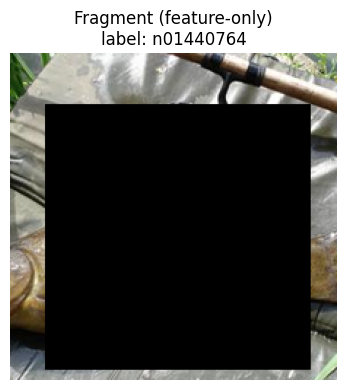

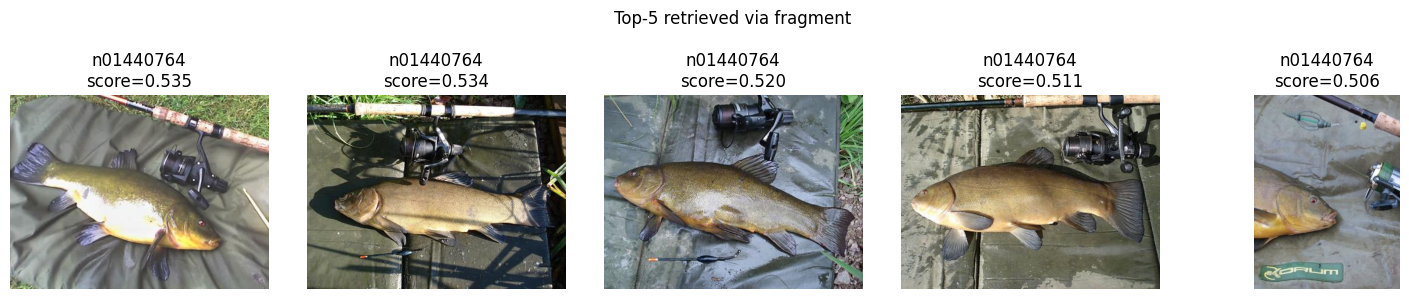

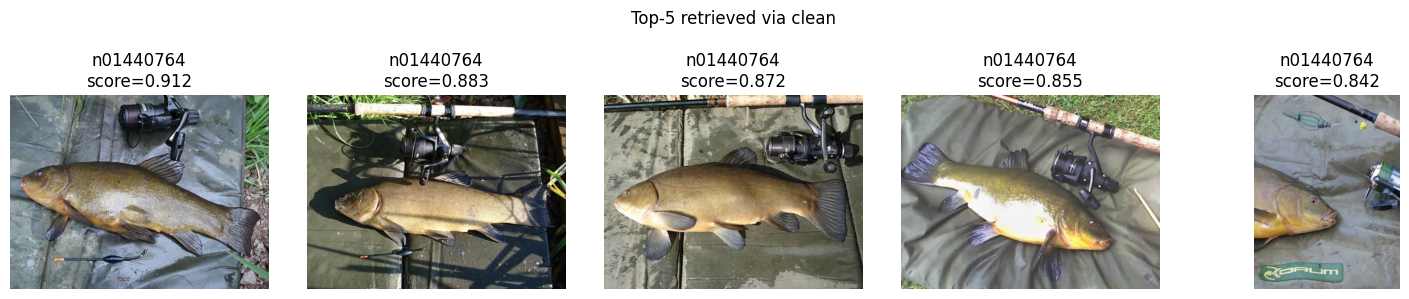

In [7]:
SAMPLE_INDEX = None  # set to an integer to pick deterministically
records = samples.get("records", [])
if not records:
    raise ValueError("samples.json does not contain any visualization records.")

if SAMPLE_INDEX is not None:
    record = records[SAMPLE_INDEX]
else:
    record = random.choice(records)
inspect_record(record, max_k=metrics["k"])


## Compare samples across corruption levels

Select multiple run names to visualize different fragment severities side-by-side.

Run: retrieval_imagination_mlp | scheme=occlude | range=[0.5, 0.7] | k=5
Num queries: 3925
Query #2 | label: n01440764
Clean image: /home/jianggy/.fastai/data/imagenette2-320/val/n01440764/ILSVRC2012_val_00017472.JPEG


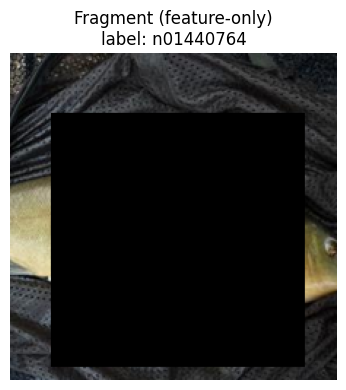

In [8]:
RUN_NAMES = [run['name'] for run in runs]  # edit to a subset like ['retrieval_imagination_occlude_010', 'retrieval_imagination_occlude_090']
MULTI_SAMPLE_INDEX = None  # optional shared index for reproducibility

def select_run(name: str):
    return next((r for r in runs if r['name'] == name), None)

def pick_record(run, sample_index=None):
    records = run['samples'].get('records', [])
    if not records:
        raise ValueError(f"Run {run['name']} has no visualization records.")
    if sample_index is not None and 0 <= sample_index < len(records):
        return records[sample_index]
    return random.choice(records)

for name in RUN_NAMES:
    run = select_run(name)
    if run is None:
        print(f"Run {name} not found, skipping.")
        continue
    metrics = run['metrics']
    record = pick_record(run, MULTI_SAMPLE_INDEX)
    print('=' * 80)
    print(f"Run: {name} | scheme={metrics.get('scheme')} | range={metrics.get('corrupt_range')} | k={metrics.get('k')}")
    print(f"Num queries: {metrics.get('num_queries')}")
    inspect_record(record, max_k=metrics.get('k', 5))
